# Ship Detection in the Port of Los Angeles (POLA)

In this notebook the labelled dataset
https://www.kaggle.com/rhammell/ships-in-satellite-imagery
is used to train a model to detect the presence of ships in the Port of Los Angeles.

I have also used 
https://towardsdatascience.com/train-image-recognition-ai-with-5-lines-of-code-8ed0bdd8d9ba
as a guide for the training of the machine learning model

In [1]:
# Let's see if it will import:
with open('POLA_vis_images.txt', 'r') as file:  
    POLA_tifs = [tif.rstrip() for tif in file.readlines()]

In [2]:
import json, sys, random
from pathlib import Path
from wand.image import Image
import numpy as np
from imageai.Prediction.Custom import ModelTraining
import rasterio
import matplotlib.pyplot as plt

In [3]:
# The code below has been run in a Google Colab session in order to quickly train the model
#model_trainer = ModelTraining()
#model_trainer.setModelTypeAsResNet()
#model_trainer.setDataDirectory("ships_sat")
#model_trainer.trainModel(num_objects=2, num_experiments=20, enhance_data=True, batch_size=32, show_network_summary=True)

Now we sca over the image in 80x80 squares to find the ones that contain ships. We begin by loading a trial image and work out how to go about the scanning process

In [4]:
# Path to the images folder
path = '..//..//..//Prep_Analysis//'

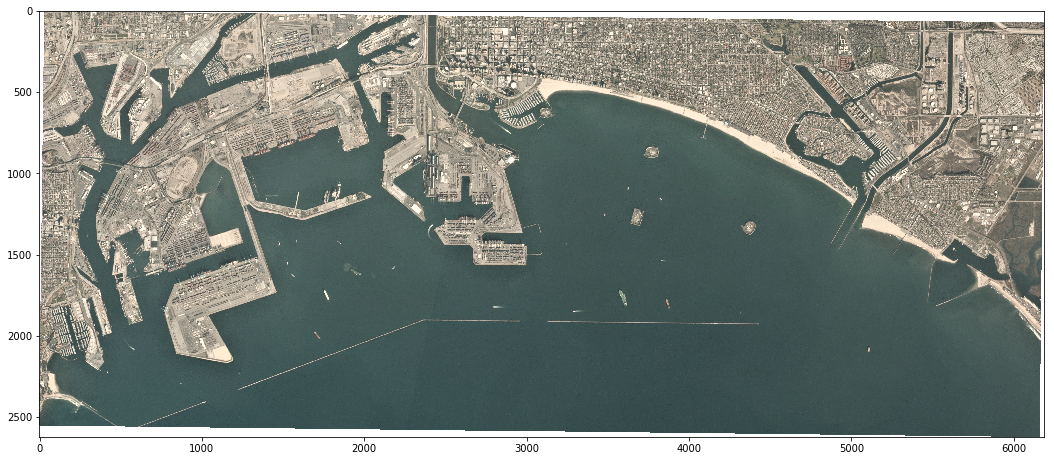

In [5]:
# Open and read the .tif file
img1 = rasterio.open(path+'images//'+POLA_tifs[0]).read()

# Display the image:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(img1))
plt.show()

In [6]:
# Make a folder to hold full png conversions of the .tif files
if Path(path+'images//full_png_imgs//').exists() == False:
    Path.mkdir(path+'images//full_png_imgs')

In [7]:
# Convert .tif to .png:
if Path('images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png').exists() == False:
    with Image(filename=path+'images//'+POLA_tifs[0]) as org_img:
        with org_img.convert('png') as conv_img:
            conv_img.sample(int(org_img.size[0]),int(org_img.size[1]))
            conv_img.save(filename=path+'images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png')

C:\Users\Ronald Maj\AppData\Local\conda\conda\envs\TDI-Challenge\lib\site-packages\wand\image.py:4623: CoderWarning: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/999
  self.raise_exception()


In [8]:
png1 = rasterio.open(path+'images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png').read()

C:\Users\Ronald Maj\AppData\Local\conda\conda\envs\TDI-Challenge\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [9]:
img1.shape

(4, 2623, 6186)

In [10]:
png1.shape

(4, 2623, 6186)

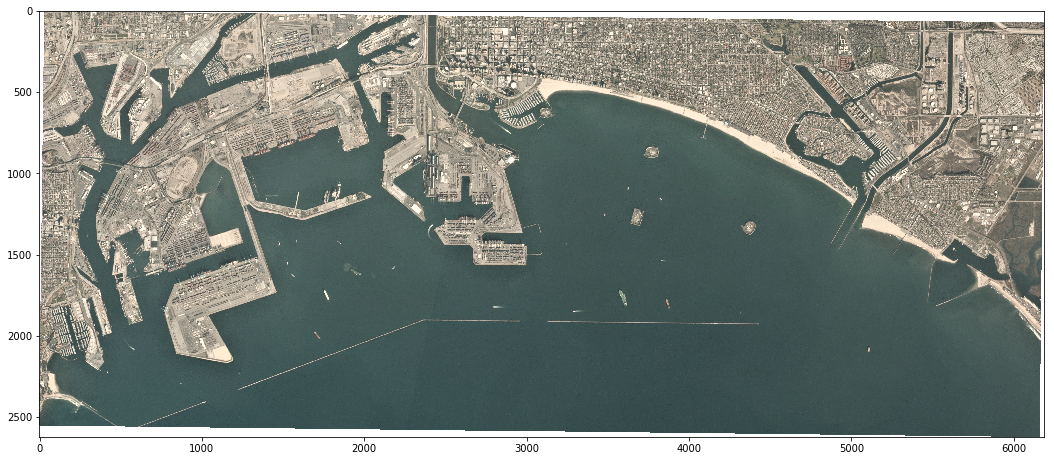

In [11]:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(png1))
plt.show()

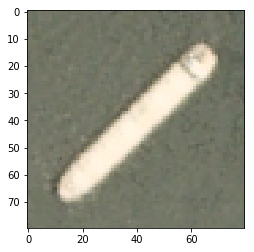

In [12]:
# Display what the images the model was trained on look like:
ship_path = 'ships-in-satellite-imagery//shipsnet//ships//'
ship1 = rasterio.open(path+ship_path+'1__20180712_180755_0f2d__-118.15166889302655_33.73582571921725'+'.png').read()

plt.figure()
plt.imshow(np.dstack(ship1))
plt.show()

In [13]:
ship1.shape

(3, 80, 80)

In [14]:
# As the ship images only have three layers (RGB) we will need to make sure that only the first three layers are used
png1[0:3].shape

(3, 2623, 6186)

In [15]:
import math

print('''We can have {} 80x80 squares in the vertical direction and {} 
squares in the horizontal direction, which rounds down to {} and {}, respectively'''.format(2623/80,6186/80,\
                                                                                       math.floor(2623/80),math.floor(6186/80)))


We can have 32.7875 80x80 squares in the vertical direction and 77.325 
squares in the horizontal direction, which rounds down to 32 and 77, respectively


Therefore, we will be able to divide each image into a grid of 32 by 77 80x80 squares, with some missing space on the edges.

We will choose the top left corner as the first 80x80 square and then proceed from there.

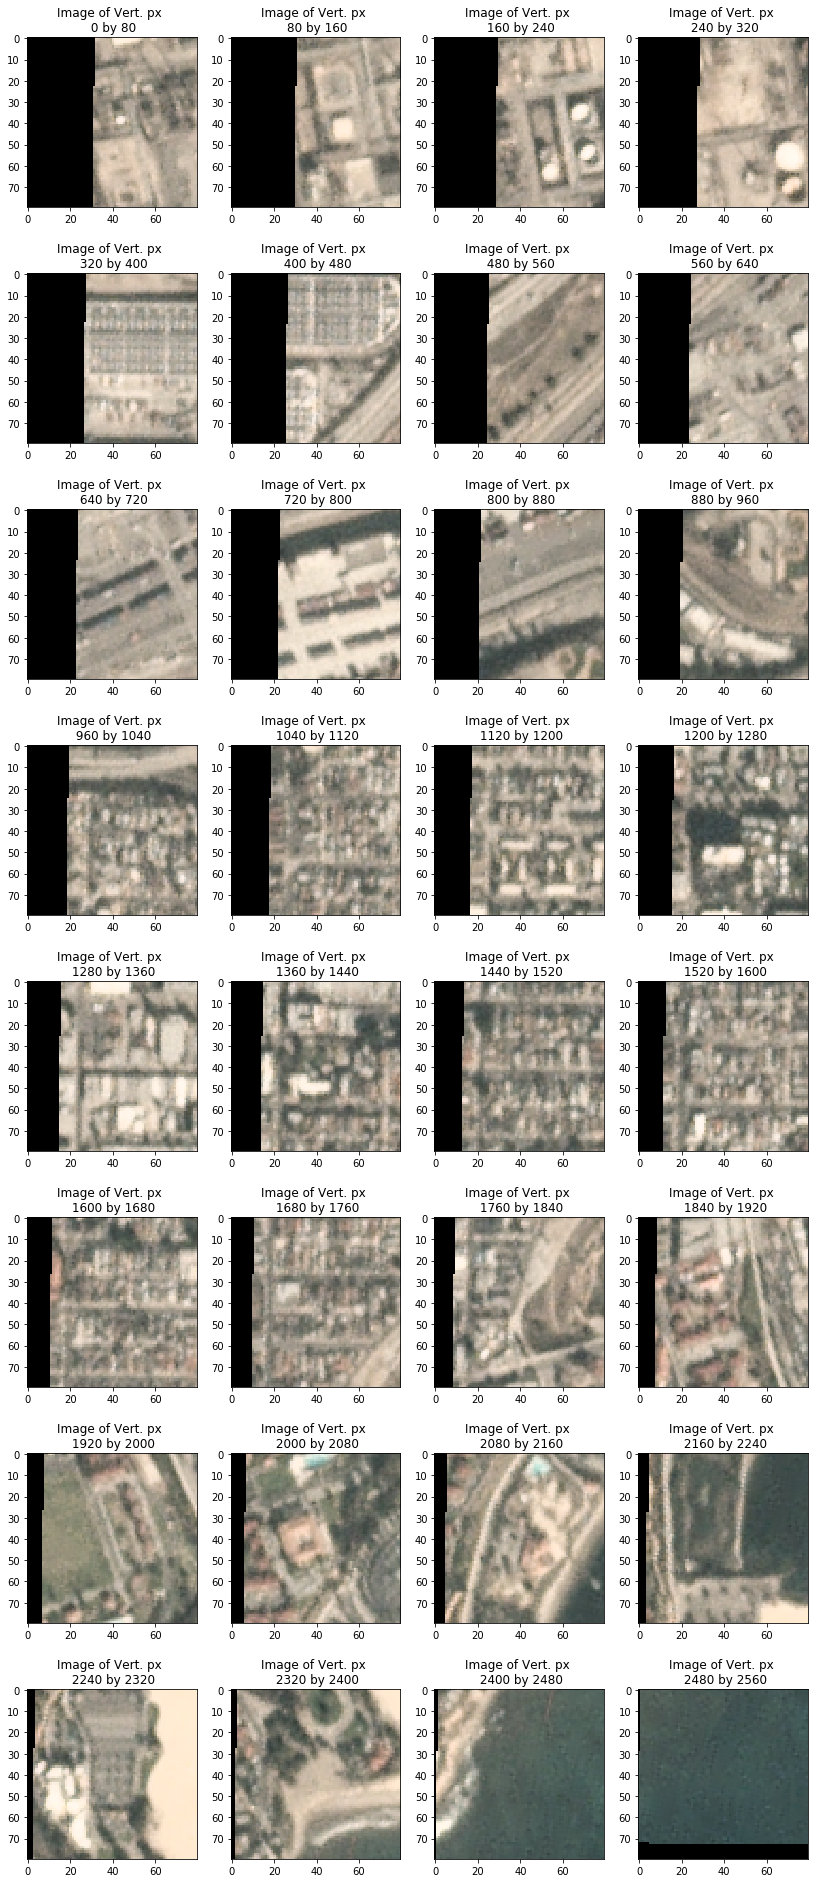

In [76]:
fig, axes = plt.subplots(8, 4)
fig.set_figheight(34)
fig.set_figwidth(14)
png1_3 = png1[0:3]
mn = 0
mx = mn+80
for i in range(8):
    for j in range(4):
        axes[i,j].imshow(np.dstack(png1_3[0:3,mn:mx,0:80]))
        axes[i,j].set_title('Image of Vert. px \n {} by {}'.format(mn,mx))
        mn += 80
        mx = mn+80

#plt.tight_layout()
plt.show()

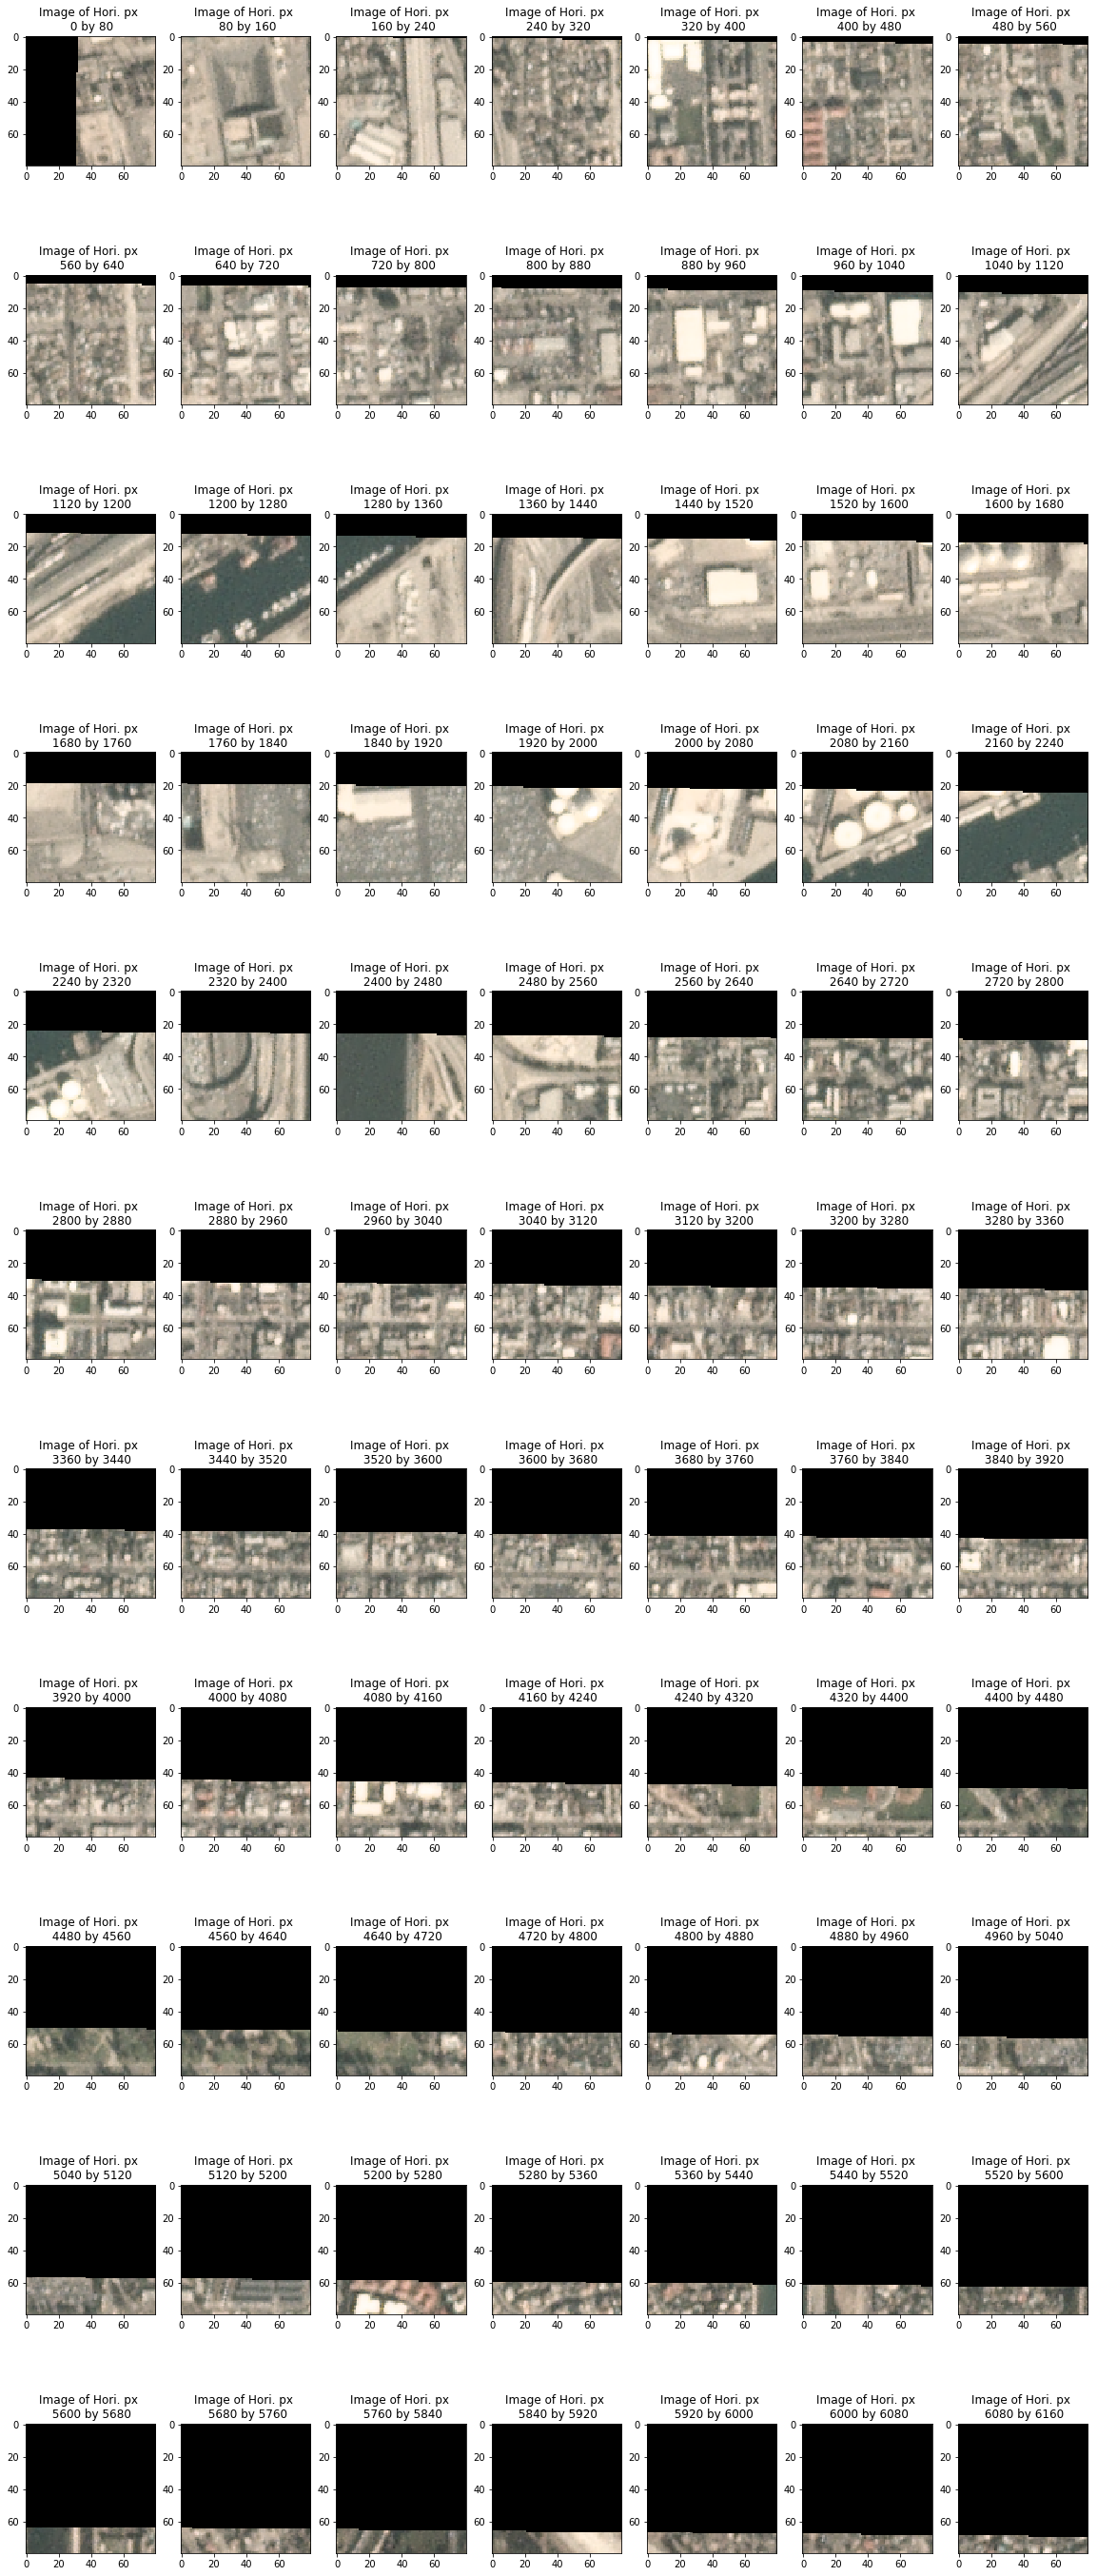

In [69]:
# Looks pretty good, now to try the horizontal:
fig, axes = plt.subplots(11, 7)
fig.set_figheight(50)
fig.set_figwidth(20)
png1_3 = png1[0:3]
mn = 0
mx = mn+80
for i in range(11):
    for j in range(7):
        axes[i,j].imshow(np.dstack(png1_3[0:3,0:80,mn:mx]))
        axes[i,j].set_title('Image of Hori. px \n {} by {}'.format(mn,mx))
        mn += 80
        mx = mn+80

#plt.tight_layout()
plt.show()

Now we pass these images through to the model that was trained previously. We do this for all the 80x80 squares and find the ones that have the highest predictive value for the ship category. 